In [2]:
import shioaji as sj
from datetime import datetime, timedelta
import pandas as pd
import pytz
import json
import matplotlib.pyplot as plt
import time
import plotly.graph_objects as go
import numpy as np

%matplotlib inline

import os
parent = os.path.dirname(os.path.abspath("__file__"))

In [3]:
api = sj.Shioaji()

api.login('F128497445', '89118217k')

In [4]:
from typing import Callable, List
from enum import Enum

from datetime import datetime, timedelta

from typing import List
from copy import deepcopy

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
        
class BaseData(AttrDict):
    
    def __init__(self, *args, **kwargs):
        super(BaseData, self).__init__(*args, **kwargs)
        
class TickData(BaseData):
    """
    儲存即時收到的Info報價
    """
    def __init__(self, *args, **kwargs):
        super(TickData, self).__init__(*args, **kwargs)
        
class BarData(BaseData):
    """
    儲存即時收到的Info報價
    """
    def __init__(self, *args, **kwargs):
        super(BarData, self).__init__(*args, **kwargs)

class TradeMode(Enum):
    """
    交易模式
    """
    REALTIME = '實盤交易'
    SIMULATION = '模擬交易'
    BACKTEST = '回測'
    BACKTESTINTRADAY = '日內回測'

# 資料格式 (RealTime)
class Interval(Enum):
    """
    資料頻率
    """
    TICK = '逐筆'
    MINUTE = '分K'
    HOUR = '小時K'
    DAILY = '日K'

class BarGenerator:
    """
    For:
    1. generateing x minute bar/x hour bar data from tick data

    Notice:
    1. x can be any number
    """

    def __init__(self, ticker: str, interval: Interval = Interval.MINUTE, window: int = 5,
                 trademode: TradeMode = TradeMode.REALTIME, 
                 callback: Callable = None, size=15, date=datetime.today()):
        """
        Constructor
        """
        self.ticker = ticker
        self.interval = interval
        self.window = window
        self._trademode = trademode
        self.callback = callback

        self.date = date
        self.setupBarCycle(interval, window)
        self.bars: List[BarData] = []
        self.inited = False
        self.barCount = 0
        self.size = size

    def setupBarCycle(self, interval, window) -> None:
        if self._trademode in [TradeMode.REALTIME, TradeMode.SIMULATION]:
            self.current = self.date.replace(hour=8,minute=45,second=0,microsecond=0)#datetime.now().replace(second=0)
        elif self._trademode == TradeMode.BACKTESTINTRADAY:
            self.current = 84500
#         print(self.current)
        self._intervalCycle(interval, window)

    def _intervalCycle(self, interval: Interval, window: int):
        if self._trademode in [TradeMode.REALTIME, TradeMode.SIMULATION]:
            if interval == Interval.MINUTE:
                self.cycle = timedelta(seconds=60 * window)
            elif interval == Interval.HOUR:
                self.cycle = timedelta(seconds=60 * 60 * window)
        elif self._trademode == TradeMode.BACKTESTINTRADAY:
            if interval == Interval.MINUTE:
                self.cycle = 100 * window
            elif interval == Interval.HOUR:
                self.cycle = 100 * 100 * window

    def updateBar(self, tick: TickData):
        try:
            if self._trademode == TradeMode.BACKTESTINTRADAY:
                return self._updateBarBacktest(tick)
            return self._updateBar(tick)
        except:
            raise

    def _updateBar(self, tick: TickData):
        try:
            try:
                time, close, volume = tick.time, tick.close, tick.volume
            except:
                # print(tick)
                time, close, volume = tick['time'], tick['close'], tick['volume']
#             print(tick, '\t', self.current)
            if not self.bars or time > self.current:
                self.bars.append(self._createNewBar(time, close, volume))
                self._updateCurBarTime()
                if len(self.bars) >= self.size:
                    self.inited = True
                if len(self.bars) > 1:
#                     print(self.bars[-2])
                    return self.bars[-2]
                    if self.callback:
                        self.callback(self.bars[-2])
            else:
                self._updateCurBar(close, volume)
        except Exception as e:
            print(e)
            raise

    def _updateBarBacktest(self, tick: TickData):
        time, close, volume = tick.time, tick.close, tick.volume
        if not self.bars or time > self.current:
            self.bars.append(self._createNewBar(time, close, volume))
            self._updateCurBarTime()
            if len(self.bars) >= self.size:
                self.inited = True
            if len(self.bars) > 1:
                self.callback(self.bars[-2])
        else:
            self._updateCurBar(close, volume)
            
    def _createNewBar(self, time, close, volume):
        return BarData(
                    symbol=self.ticker,
                    time=time,
                    open=close,
                    high=close,
                    low=close,
                    close=close,
                    volume=volume
                )
    
    def _updateCurBar(self, close, volume):
        curBar = self.bars[-1]
        curBar.high = max(curBar.high, close)
        curBar.low = min(curBar.low, close)
        curBar.close = close
        curBar.volume += volume
        self.bars[-1] = curBar

    def _updateCurBarTime(self):
        self.current += self.cycle
#         if self._trademode in [TradeMode.REALTIME, TradeMode.SIMULATION]:
#             return
        if self._trademode == TradeMode.BACKTESTINTRADAY:
            timeList = self._intTolist(self.current)
            if self.interval == Interval.MINUTE:
                if timeList[1] >= 60:
                    timeList[0] += 1
                    timeList[1] -= 60
            if timeList[0] >= 24:
                timeList[0] -= 24
            self.current = int(''.join([str(int(x)) for x in timeList]))

    def _intTolist(self, t):
        ss = t % 100
        t /= 100
        mm = t % 100
        hh = t / 100
        return [int(hh), int(mm), int(ss)]

    @property
    def closes(self):
        return [getattr(bar, 'close') for bar in self.bars][:-1]

    @property
    def opens(self):
        return [getattr(bar, 'open') for bar in self.bars][:-1]

    @property
    def highs(self):
        return [getattr(bar, 'high') for bar in self.bars][:-1]

    @property
    def lows(self):
        return [getattr(bar, 'low') for bar in self.bars][:-1]

    @property
    def volumes(self):
        return [getattr(bar, 'volume') for bar in self.bars][:-1]
    
    @property
    def times(self):
        return [getattr(bar, 'time') for bar in self.bars][:-1]

In [5]:
def getNearbyCode(td:datetime):
    month = getNearbyMonth(td)
    return [chr(m+65-1), chr(m+65-1+12)]
    
def getNearbyMonth(td: datetime = None):
    if not td:
        td = datetime.today()
    month = td.month
    if isTimetoMaturity(td): 
        month += 1
        if month > 12:
            month = 1
    return month

def getExistsContract(date: datetime, strikes:list, symbol:str='TXF', months:int=3) -> list:
    global call_code_map, put_code_map, opt_ticker_map
    opt_ticker = opt_ticker_map[symbol]
    Conti_Ms = getExistsContractMonth(date)
    contracts = []
    y = date.year
    next_y = y + 1
    for strike in strikes:
        strike = StrikeFill(strike, symbol)
        
        for m in Conti_Ms[:months]:
            call_ticker = f'{opt_ticker}{str(strike).zfill(5)}{call_code_map[m]}{str(y)[-1]}'
            put_ticker = f'{opt_ticker}{str(strike).zfill(5)}{put_code_map[m]}{str(y)[-1]}'
            if 12 in Conti_Ms[1:3]:
                if m < 12:
                    call_ticker = f'{opt_ticker}{str(strike).zfill(5)}{call_code_map[m]}{str(next_y)[-1]}'
                    put_ticker = f'{opt_ticker}{str(strike).zfill(5)}{put_code_map[m]}{str(next_y)[-1]}'
            contracts.extend([call_ticker, put_ticker])
    return contracts

def getExistsContractMonth(date):
    month = getNearbyMonth(date)
    conti_Ms = [x if x <= 12 else x - 12 for x in range(month, month + 3)]
    if conti_Ms[-1] in [3, 4, 5]: # 3個連續月份的最後一個月是3或4或5，判斷連續季月月份，以下雷同
        conti_Ms.extend([6, 9, 12])
    elif conti_Ms[-1] in [6, 7, 8]:
        conti_Ms.extend([9, 12, 3])
    elif conti_Ms[-1] in [9, 10, 11]:
        conti_Ms.extend([12, 3, 6])
    elif conti_Ms[-1] in [12, 1, 2]:
        conti_Ms.extend([3, 6, 9])
    return conti_Ms

def isTimetoMaturity(td):
    thirdWendesday = getThirdWendesday(td)
    if td.strftime('%Y%m%d') >= thirdWendesday.strftime('%Y%m%d'): 
        return True
    return False

def getThirdWendesday(td):
    week = 2
    first_wendesday = getFirstWendesday(td)
    return first_wendesday + timedelta(week * 7)

def getFirstWendesday(td):
    first_day = datetime(td.year, td.month, 2)
    if first_day.weekday() <= 2:
        adj_days = 2 - first_day.weekday()
    else:
        adj_days = 9 - first_day.weekday()
    return first_day + timedelta(adj_days)

def getContiCode(td:datetime):
    m = getNearbyMonth(td)
    next_m = (m + 1) % 12
    if not next_m:
        next_m = 12
    if m+1 > 12: 
        return [chr(m+65-1)+str(td.year)[-1], chr(next_m+65-1)+str(td.year + 1)[-1]]
    else:
        return [chr(m+65-1)+str(td.year)[-1], chr(next_m+65-1)+str(td.year)[-1]]
    

In [6]:
def ReadData(date):
    data_path = os.path.join(parent, "HistoricData", "MXF")
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
#     for k, v in dfs.items():
    tdStr = date.strftime("%Y-%m-%d")
    try:
        with open(os.path.join(data_path, f"MXF_{tdStr}.json"), 'r') as f:
            data = json.load(f)
            df = pd.DataFrame(data)
            df.datetime = pd.to_datetime(df.datetime)
        return df.set_index('datetime')
    except:
        return pd.DataFrame()
    
def WriteData(date, df):
    data_path = os.path.join(parent, "HistoricData", "MXF")
    tdStr = date.strftime("%Y-%m-%d")
    with open(os.path.join(data_path, f"MXF_{tdStr}.json"), 'w') as f:
        df = df.reset_index()
        df.datetime = df.datetime.apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S.%f"))
        json.dump(list(df.T.to_dict().values()), f)

def GetPairData(api, date:datetime=datetime(2021,11,5)):
    df = ReadData(date)
    if not df.empty:
        return df
    dateStr = date.strftime("%Y-%m-%d")
    last_code = getContiCode(date)
    today_last_code = getContiCode(datetime.today())
    
    contract_nearby = api.Contracts.Futures["MXF"+today_last_code[0]]
    contract_nearby.code = "MXF"+last_code[0]
    data_nearby = api.ticks(contract_nearby, dateStr, 
                            query_type=sj.constant.TicksQueryType.RangeTime, 
                            time_start='08:45:00',#datetime(2021,11,5,8,45,0).time(),
                           time_end='13:45:00')#datetime(2021,11,5,13,45,0).time())

    df_nearby = pd.DataFrame(data_nearby.dict())
    df_nearby['datetime'] = df_nearby.ts.apply(lambda x: datetime.utcfromtimestamp(int(str(x)[:10])).astimezone(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d %H:%M:%S.")+str(x)[10:16])
    df_nearby['datetime'] = pd.to_datetime(df_nearby['datetime'])

    df_nearby = df_nearby.set_index('datetime')
    WriteData(date, df_nearby)
    return df_nearby

def GetPairDataBar(api, date:datetime=datetime(2021,11,5)):
    df = ReadData(date)
    if not df.empty:
        return df
    dateStr = date.strftime("%Y-%m-%d")
    last_code = getContiCode(date)
    today_last_code = getContiCode(datetime.today())
    
    contract_nearby = api.Contracts.Futures["MXF"+today_last_code[0]]
    contract_nearby.code = "MXF"+last_code[0]
    data_nearby = api.ticks(contract_nearby, dateStr, 
                            query_type=sj.constant.TicksQueryType.RangeTime, 
                            time_start='08:45:00',#datetime(2021,11,5,8,45,0).time(),
                           time_end='13:45:00')#datetime(2021,11,5,13,45,0).time())

    df_nearby = pd.DataFrame(data_nearby.dict())
    df_nearby['datetime'] = df_nearby.ts.apply(lambda x: datetime.utcfromtimestamp(int(str(x)[:10])).astimezone(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d %H:%M:%S.")+str(x)[10:16])
    df_nearby['datetime'] = pd.to_datetime(df_nearby['datetime'])

    df_nearby = df_nearby.set_index('datetime')
    return df_nearby

In [202]:
def Backtest(df, takeprofit = 20, stop_loss = 40, gap_threshold = 0.1, 
             inverse_threshold=80, pre_day_close = None, window=3, ma_len=3,ma_len2=5,
             date=datetime(2022,2,18), early_stop=True):

    setup_param = False
    entry = sig = pos = 0
    interval_h = 0 # 區間高點
    interval_l = 99999 # 區間低點
    gap = 0
    
    result = []
    pre_close = None
    total_pnl = 0
    total_win = 0
    total_loss = 0
    win_trade = 0
    loss_trade = 0
    record = {}
    end_Trade = False
    tmp_min_pnl = tmp_max_pnl = min_pnl = max_pnl = 0
    tmp_sl = 10 # stoploss
    loss_num = 0
    max_unreal = 0
    max_price = 0
    min_price = 99999
    entry = 0
    zero_trade = 0
    sig_inverse = 1
    critical_h = critical_l = None
    prefer_short = prefer_long = False
    check_dir = False
    bar_ratio = 2
    mini_bar_width = 10
    pre_bar = None
    if window == 15:
        bar_ratio = 1
        mini_bar_width = 20
    follow_trend = False
#     if pre_day_close:
#         critical_h = pre_day_close * 1.007
#         critical_l = pre_day_close * 0.993
#         print(critical_h, critical_l)
    barG = BarGenerator(ticker="MXF", window=window, date=date)
#     tPrices = []
#     Vols = []
#     P_v = []
#     VWAP = []
#     d_vwap = 0
#     max_d_vwap = 0
#     under_vwap = above_vwap = False
#     MA1 = []
#     MA2 = []
    inter_h = []
    inter_l = []
    
    for row in df.itertuples():
#         print(row)
        tick = TickData(time=row.Index, close=row.close,volume=row.volume)
#         print(tick)
        update_bar = barG.updateBar(tick)
#         print(update_bar)
        if update_bar:
            if update_bar.volume > window * 1.1 * 1000:
                inter_h.append(update_bar.high)
                inter_l.append(update_bar.low)
            else:
                if len(inter_h):
                    inter_h.append(inter_h[-1])
                    inter_l.append(inter_l[-1])
            if len(inter_h) <= 1:
                continue
#             print(update_bar)
#             tPrice = (update_bar.close + update_bar.high + update_bar.low) / 3
#             tPrices.append(tPrice)
#             P_v.append(tPrice * update_bar.volume)
#             Vols.append(update_bar.volume)
#             VWAP.append(sum(P_v) / sum(Vols))
#             if len(tPrices) > ma_len:
#                 MA1.append(np.mean(tPrices[-ma_len:]))
#             if len(tPrices) > ma_len2:
#                 MA2.append(np.mean(tPrices[-ma_len2:]))
#             if row.Index <= row.Index.replace(hour=9, minute=0, second=0, microsecond=0):
#                 pre_bar = update_bar
#                 continue
#         if len(MA1) < 2 or len(MA2) < 2:
#             continue
        if row.Index <= row.Index.replace(hour=13, minute=0, second=0, microsecond=0) and not end_Trade:
            if sig == 0 and pos == 0 and not end_Trade:
                if update_bar:
                    if inter_h[-2] == inter_h[-1]:
                        if update_bar.close >= inter_h[-1]:
                            sig = 1
                        elif update_bar.close <= inter_l[-1]:
                            sig = -1
                    else:
                        if update_bar.close >= inter_h[-2]:
                            sig = 1
                        elif update_bar.close <= inter_l[-2]:
                            sig = -1
                    
                if sig != 0:# and pos == 0:
                    print(f"{row.Index}, PreClose : {pre_close}, Close : {row.close}, Ask : {row.ask_price}, Bid : {row.bid_price}")
                    if sig > 0:
#                         if row.ask_price >= row.close:
                        entry  = row.ask_price
#                         stop_loss = entry - barG.lows[-2]
#                         if follow_trend:
#                             stop_loss = (entry - min(barG.lows[-ma_len:-1]))
#                             print(en)
                    elif sig < 0:
#                         if row.bid_price <= row.close:
                        entry  = row.bid_price
#                         stop_loss = -(entry - barG.highs[-2])
#                         if follow_trend:
#                             stop_loss = -(entry - max(barG.highs[-ma_len:-1]))
                    if entry:
                        pos = sig
                        
#                         stop_loss = interval_h
#                         if sig > 0:
#                             stop_loss = interval_l
                        print(f'Entry : {entry}, pos : {pos} at ts : {row.Index}, Close = {row.close}, StopLoss = {stop_loss}')
                    sig = 0
            if sig == 0 and pos != 0:
                if pos < 0:
                    exit = min(row.ask_price, row.close)
#                     min_price = min(min_price, row.close)
                elif pos > 0:
                    exit = max(row.bid_price, row.close)
                if abs(exit - row.close) >= 3:
                    exit = row.close
#                     max_price = max(max_price, row.close)
                
                tmp_pnl = (exit - entry) * pos
                tmp_max_pnl = max(tmp_max_pnl, tmp_pnl)
                tmp_min_pnl = min(tmp_min_pnl, tmp_pnl)
                
#                 if update_bar:
# #                     d_vwap = abs(tPrice - VWAP[-1])
                    
# #                     if d_vwap > max_d_vwap and d_vwap > 0:
# #                         max_d_vwap = d_vwap
# #                     if d_vwap / max_d_vwap <= 2/3:
# #                         if len(MA) >= 3:
# #                             if np.sign(MA[-2] / MA[-3]) != np.sign(MA[-1] / MA[-2]):
# #                                 sig=-pos
#                     if MA1[-2] <= MA2[-2] and MA1[-1] > MA2[-1] and pos < 0:
#                         sig = 1
#                     elif MA1[-2] >= MA2[-2] and MA1[-1] < MA2[-1] and pos > 0:
#                         sig = -1
                
                if tmp_pnl >= takeprofit:
                    sig = -pos
#                 if update_bar:
#                     if update_bar.close >= interval_h and pos < 0:
#                         sig = -pos
#                     elif update_bar.close <= interval_l and pos > 0:
#                         sig = -pos
#                     if update_bar:
                if tmp_pnl <= -stop_loss:
                    sig = -pos
#     #                         if update_bar.close <= (entry - stop_loss) * pos:
#                             print(update_bar.close, entry, stop_loss, entry - stop_loss)

                    
#                 print(tmp_pnl, sig)
#                     if update_bar.close > MA5[-1] and MA5[-1] > MA5[-2]:
#                         sig = 1
#                     elif update_bar.close < MA5[-1] and MA5[-1] < MA5[-2]:
#                         sig = -1
#                 if barG.closes[-1] >= MA[-1] and pos < 0: # barG.closes[-2] <= MA[-2] and 
#                     sig = -pos
#                 if barG.closes[-1] <= MA[-1] and pos > 0: # barG.closes[-2] >= MA[-2] and 
#                     sig = -pos
                if sig != 0:
                    print(f"Max Pnl : {tmp_max_pnl}, Min Pnl : {tmp_min_pnl}")
                    tmp_min_pnl = tmp_max_pnl = 0
                    print(f"PreClose : {pre_close}, Close : {row.close}, Ask : {row.ask_price}, Bid : {row.bid_price}")
                    pnl = (exit - entry) * pos - 2
                    total_pnl += pnl #- 2
                    if pnl > 0:
                        win_trade += 1
                        total_win += pnl
                    elif pnl < 0:
                        loss_trade += 1
                        total_loss += pnl
                    else:
                        zero_trade += 1
                    print(f'Exit : {exit}, pnl : {pnl}, total_pnl : {total_pnl} at ts : {row.Index}, Close = {row.close}\n')
                    max_unreal = entry = exit = pos = sig = 0
                    max_pnl = max(total_pnl, max_pnl)
                    min_pnl = min(total_pnl, min_pnl)
                    max_price = 0
                    min_price = 99999
                    tmp_max_pnl = tmp_min_pnl = 0
                    follow_trend = False
                    d_vwap = max_d_vwap = 0
#                 if total_pnl > 0 or (loss_trade >= 2 and not win_trade) or (loss_trade > 2 and win_trade):
                if (total_pnl > 0 or total_pnl <= -3 * stop_loss) and early_stop :#loss_trade:
                    end_Trade = True
        else:
            if not pos:continue
            if row.Index <= row.Index.replace(hour=13, minute=30, second=0, microsecond=0):
                if pos < 0:
                    exit = min(row.ask_price, row.close)
#                     min_price = min(min_price, row.close)
                elif pos > 0:
                    exit = max(row.bid_price, row.close)
#                     max_price = max(max_price, row.close)
                if abs(exit - row.close) >= 3:
                    exit = row.close
                
                tmp_pnl = (exit - entry) * pos
                tmp_max_pnl = max(tmp_max_pnl, tmp_pnl)
                tmp_min_pnl = min(tmp_min_pnl, tmp_pnl)
                if tmp_pnl >= takeprofit:
                    sig = -pos
                if tmp_pnl <= -stop_loss:
                    sig = -pos
#                 print(tmp_pnl)
#                 if update_bar:
#                     if MA1[-1] > MA2[-1] and pos < 0: # MA1[-2] <= MA2[-2] and 
#                         sig = 1
#                     elif MA1[-1] < MA2[-1] and pos > 0: # MA1[-2] >= MA2[-2] and 
#                         sig = -1
#                     d_vwap = abs(tPrice - VWAP[-1])
                    
#                     if d_vwap > max_d_vwap and d_vwap > 0:
#                         max_d_vwap = d_vwap
#                     if d_vwap / max_d_vwap <= 2/3:
#                         if len(MA) >= 3:
#                             if np.sign(MA[-2] / MA[-3]) != np.sign(MA[-1] / MA[-2]):
#                                 sig=-pos
            else:
                if pos < 0:
                    exit = row.ask_price
                elif pos > 0:
                    exit = row.bid_price
                sig = -pos

            if sig != 0:
                pnl = (exit - entry) * pos - 2
                total_pnl += pnl
                if pnl > 0:
                    win_trade += 1
                    total_win += pnl
                elif pnl < 0:
                    loss_trade += 1
                    total_loss += pnl
                else:
                    zero_trade += 1
                print(f'Exit : {exit}, pnl : {pnl}, total_pnl : {total_pnl} at ts : {row.Index}, Close = {row.close}\n')
                max_unreal = entry = exit = pos = sig = 0
                max_pnl = max(total_pnl, max_pnl)
                min_pnl = min(total_pnl, min_pnl)
                max_price = 0
                min_price = 99999
#                 if total_pnl > 0 or (loss_trade >= 2 and not win_trade) or (loss_trade > 2 and win_trade):
                if (total_pnl > 0 or total_pnl <= -3 * stop_loss) and early_stop :#loss_trade:
                    end_Trade = True
#         print(pre_close, row.close)
        pre_close = row.close
        pre_bar = update_bar
        update_bar = None
#         print(pre_close, row.close, "\n")

    avg_win = total_win / win_trade if win_trade else 0
    avg_loss = total_loss / loss_trade if loss_trade else 0
    Q = avg_win / abs(avg_loss) if avg_loss else 0
    total_trade = win_trade + loss_trade + zero_trade
    Pw = win_trade / total_trade if total_trade else 0
    Ev = Q * Pw - (1 - Pw)
    Avg_PnL = total_pnl / total_trade if total_trade else 0
    print(f"------------Strategy Result at {row.Index.strftime('%Y-%m-%d')}------------")
    print(f'Total PnL : {total_pnl}')
    print(f'Avg Win : {avg_win}')
    print(f'Num Win : {win_trade}')
    print(f'Avg Loss : {avg_loss}')
    print(f'Num Loss : {loss_trade}')
    print(f'Avg PnL : {Avg_PnL}')
    print(f'G/L : {Q}, Pw : {Pw}, Expected Value : {Ev}')
    print(f'Max Pnl : {max_pnl}, Min Pnl : {min_pnl}\n')
    print("===================End BackTest===================\n")

    return (total_pnl, avg_win, win_trade, avg_loss, loss_trade, Avg_PnL, Q, Pw, Ev)

In [46]:
date = datetime(2022,1,24)
df = GetPairData(api, date=date)

In [170]:
date = datetime(2021,1,12)
# dfs[date] = GetPairData(api, date=date)
# dfs[date].close.plot(figsize=(12,8))
df = GetPairData(api, date)
result = Backtest(df, takeprofit = 50, stop_loss = 35, gap_threshold=0.3, 
                  inverse_threshold=80, pre_day_close = 17896, 
                  date=date,window=5, ma_len=3, ma_len2=5)

2021-01-12 09:20:00.224000, PreClose : 15555.0, Close : 15556.0, Ask : 15556.0, Bid : 15555.0
Entry : 15555.0, pos : -1 at ts : 2021-01-12 09:20:00.224000, Close = 15556.0, StopLoss = 35
Max Pnl : 50.0, Min Pnl : -6.0
PreClose : 15506.0, Close : 15505.0, Ask : 15507.0, Bid : 15506.0
Exit : 15505.0, pnl : 48.0, total_pnl : 48.0 at ts : 2021-01-12 09:24:48.855000, Close = 15505.0

------------Strategy Result at 2021-01-12------------
Total PnL : 48.0
Avg Win : 48.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 48.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 48.0, Min Pnl : 0

===================End BackTest===================



In [114]:
from concurrent.futures import ThreadPoolExecutor

In [208]:
results = {}
dfs = {}
# with ThreadPoolExecutor(4) as executors:
    
for date in pd.date_range(datetime(2021,1,4), datetime(2022,3,18)):
    try:
        if date not in dfs.keys():
            dfs[date] = GetPairData(api, date=date)
        if dfs[date] is None or dfs[date].empty:
            print(f'===============No Data on {date.strftime("%Y-%m-%d")}===============')
            continue
        print(f'===============Backtest {date.strftime("%Y-%m-%d")}===============')
        results[date] = Backtest(dfs[date], takeprofit = 35, stop_loss = 25, 
                                 gap_threshold=0.3, inverse_threshold=80, 
                                 pre_day_close = 17896, date=date, window=5)#, early_stop=False)
#         results[date] = Backtest(dfs[date], takeprofit = 8, stoploss = 30, gap_threshold=0.2,date=date)
        time.sleep(0.5)
    except KeyboardInterrupt:
        break
    except Exception as e:
        print(e)
        pass

===============Backtest 2021-01-04===============
2021-01-04 09:20:00.038000, PreClose : 14655.0, Close : 14656.0, Ask : 14656.0, Bid : 14655.0
Entry : 14655.0, pos : -1 at ts : 2021-01-04 09:20:00.038000, Close = 14656.0, StopLoss = 25
Max Pnl : 1.0, Min Pnl : -25.0
PreClose : 14679.0, Close : 14680.0, Ask : 14680.0, Bid : 14679.0
Exit : 14680.0, pnl : -27.0, total_pnl : -27.0 at ts : 2021-01-04 09:24:31.368000, Close = 14680.0

2021-01-04 09:30:00.008000, PreClose : 14721.0, Close : 14722.0, Ask : 14722.0, Bid : 14721.0
Entry : 14722.0, pos : 1 at ts : 2021-01-04 09:30:00.008000, Close = 14722.0, StopLoss = 25
Max Pnl : 35.0, Min Pnl : -17.0
PreClose : 14755.0, Close : 14757.0, Ask : 14756.0, Bid : 14755.0
Exit : 14757.0, pnl : 33.0, total_pnl : 6.0 at ts : 2021-01-04 09:49:31.156000, Close = 14757.0

------------Strategy Result at 2021-01-04------------
Total PnL : 6.0
Avg Win : 33.0
Num Win : 1
Avg Loss : -27.0
Num Loss : 1
Avg PnL : 3.0
G/L : 1.2222222222222223, Pw : 0.5, Expected

Max Pnl : 35.0, Min Pnl : -15.0
PreClose : 15717.0, Close : 15718.0, Ask : 15714.0, Bid : 15713.0
Exit : 15718.0, pnl : 33.0, total_pnl : -21.0 at ts : 2021-01-14 10:54:49.272000, Close = 15718.0

2021-01-14 10:55:00.117000, PreClose : 15716.0, Close : 15717.0, Ask : 15717.0, Bid : 15716.0
Entry : 15717.0, pos : 1 at ts : 2021-01-14 10:55:00.117000, Close = 15717.0, StopLoss = 25
Max Pnl : 35.0, Min Pnl : -22.0
PreClose : 15751.0, Close : 15752.0, Ask : 15751.0, Bid : 15750.0
Exit : 15752.0, pnl : 33.0, total_pnl : 12.0 at ts : 2021-01-14 12:03:11.897000, Close = 15752.0

------------Strategy Result at 2021-01-14------------
Total PnL : 12.0
Avg Win : 33.0
Num Win : 2
Avg Loss : -27.0
Num Loss : 2
Avg PnL : 3.0
G/L : 1.2222222222222223, Pw : 0.5, Expected Value : 0.11111111111111116
Max Pnl : 12.0, Min Pnl : -54.0

===================End BackTest===================

===============Backtest 2021-01-15===============
2021-01-15 09:05:00.005000, PreClose : 15908.0, Close : 15908.0, Ask : 

------------Strategy Result at 2021-01-27------------
Total PnL : 5.0
Avg Win : 33.0
Num Win : 1
Avg Loss : -28.0
Num Loss : 1
Avg PnL : 2.5
G/L : 1.1785714285714286, Pw : 0.5, Expected Value : 0.0892857142857143
Max Pnl : 5.0, Min Pnl : -28.0

===================End BackTest===================

===============Backtest 2021-01-28===============
2021-01-28 08:55:00.010000, PreClose : 15362.0, Close : 15361.0, Ask : 15363.0, Bid : 15361.0
Entry : 15361.0, pos : -1 at ts : 2021-01-28 08:55:00.010000, Close = 15361.0, StopLoss = 25
Max Pnl : 25.0, Min Pnl : -26.0
PreClose : 15386.0, Close : 15387.0, Ask : 15384.0, Bid : 15383.0
Exit : 15387.0, pnl : -28.0, total_pnl : -28.0 at ts : 2021-01-28 09:01:12.112000, Close = 15387.0

2021-01-28 09:05:00.040000, PreClose : 15417.0, Close : 15419.0, Ask : 15420.0, Bid : 15419.0
Entry : 15420.0, pos : 1 at ts : 2021-01-28 09:05:00.040000, Close = 15419.0, StopLoss = 25
Max Pnl : 35.0, Min Pnl : -15.0
PreClose : 15454.0, Close : 15455.0, Ask : 15454.0

2021-02-18 09:20:00.165000, PreClose : 16327.0, Close : 16327.0, Ask : 16328.0, Bid : 16326.0
Entry : 16328.0, pos : 1 at ts : 2021-02-18 09:20:00.165000, Close = 16327.0, StopLoss = 25
Max Pnl : 35.0, Min Pnl : -12.0
PreClose : 16362.0, Close : 16363.0, Ask : 16362.0, Bid : 16360.0
Exit : 16363.0, pnl : 33.0, total_pnl : 33.0 at ts : 2021-02-18 09:27:02.046000, Close = 16363.0

------------Strategy Result at 2021-02-18------------
Total PnL : 33.0
Avg Win : 33.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 33.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 33.0, Min Pnl : 0

===================End BackTest===================

===============Backtest 2021-02-19===============
2021-02-19 09:15:00.081000, PreClose : 16255.0, Close : 16255.0, Ask : 16256.0, Bid : 16255.0
Entry : 16255.0, pos : -1 at ts : 2021-02-19 09:15:00.081000, Close = 16255.0, StopLoss = 25
Max Pnl : 10.0, Min Pnl : -25.0
PreClose : 16279.0, Close : 16280.0, Ask : 16276.0, Bid : 16274.0
Exit : 16280.0, pnl : -

===============Backtest 2021-03-04===============
2021-03-04 09:05:00.046000, PreClose : 16005.0, Close : 16005.0, Ask : 16007.0, Bid : 16006.0
Entry : 16006.0, pos : -1 at ts : 2021-03-04 09:05:00.046000, Close = 16005.0, StopLoss = 25
Max Pnl : 15.0, Min Pnl : -26.0
PreClose : 16031.0, Close : 16032.0, Ask : 16029.0, Bid : 16028.0
Exit : 16032.0, pnl : -28.0, total_pnl : -28.0 at ts : 2021-03-04 09:10:47.468000, Close = 16032.0

2021-03-04 09:15:00.030000, PreClose : 16027.0, Close : 16027.0, Ask : 16028.0, Bid : 16027.0
Entry : 16028.0, pos : 1 at ts : 2021-03-04 09:15:00.030000, Close = 16027.0, StopLoss = 25
Max Pnl : 26.0, Min Pnl : -25.0
PreClose : 16003.0, Close : 16003.0, Ask : 16003.0, Bid : 16002.0
Exit : 16003.0, pnl : -27.0, total_pnl : -55.0 at ts : 2021-03-04 09:27:01.754000, Close = 16003.0

2021-03-04 09:40:00.053000, PreClose : 15956.0, Close : 15955.0, Ask : 15956.0, Bid : 15955.0
Entry : 15955.0, pos : -1 at ts : 2021-03-04 09:40:00.053000, Close = 15955.0, StopLoss

===============Backtest 2021-03-09===============
2021-03-09 09:10:00.001000, PreClose : 15801.0, Close : 15801.0, Ask : 15804.0, Bid : 15802.0
Entry : 15804.0, pos : 1 at ts : 2021-03-09 09:10:00.001000, Close = 15801.0, StopLoss = 25
Max Pnl : 21.0, Min Pnl : -25.0
PreClose : 15780.0, Close : 15779.0, Ask : 15783.0, Bid : 15782.0
Exit : 15779.0, pnl : -27.0, total_pnl : -27.0 at ts : 2021-03-09 09:18:06.160000, Close = 15779.0

2021-03-09 09:20:00.045000, PreClose : 15776.0, Close : 15776.0, Ask : 15776.0, Bid : 15775.0
Entry : 15775.0, pos : -1 at ts : 2021-03-09 09:20:00.045000, Close = 15776.0, StopLoss = 25
Max Pnl : 35.0, Min Pnl : -6.0
PreClose : 15741.0, Close : 15740.0, Ask : 15742.0, Bid : 15741.0
Exit : 15740.0, pnl : 33.0, total_pnl : 6.0 at ts : 2021-03-09 09:24:18.323000, Close = 15740.0

------------Strategy Result at 2021-03-09------------
Total PnL : 6.0
Avg Win : 33.0
Num Win : 1
Avg Loss : -27.0
Num Loss : 1
Avg PnL : 3.0
G/L : 1.2222222222222223, Pw : 0.5, Expected

------------Strategy Result at 2021-03-16------------
Total PnL : -83.0
Avg Win : 0
Num Win : 0
Avg Loss : -27.666666666666668
Num Loss : 3
Avg PnL : -27.666666666666668
G/L : 0.0, Pw : 0.0, Expected Value : -1.0
Max Pnl : 0, Min Pnl : -83.0

===================End BackTest===================

===============Backtest 2021-03-17===============
------------Strategy Result at 2021-03-17------------
Total PnL : 0
Avg Win : 0
Num Win : 0
Avg Loss : 0
Num Loss : 0
Avg PnL : 0
G/L : 0, Pw : 0, Expected Value : -1
Max Pnl : 0, Min Pnl : 0

===================End BackTest===================

===============Backtest 2021-03-18===============
2021-03-18 09:10:00.092000, PreClose : 16286.0, Close : 16285.0, Ask : 16286.0, Bid : 16285.0
Entry : 16286.0, pos : 1 at ts : 2021-03-18 09:10:00.092000, Close = 16285.0, StopLoss = 25
Max Pnl : 29.0, Min Pnl : -25.0
PreClose : 16263.0, Close : 16261.0, Ask : 16263.0, Bid : 16261.0
Exit : 16261.0, pnl : -27.0, total_pnl : -27.0 at ts : 2021-03-18 09:17:36.2

Max Pnl : 35.0, Min Pnl : -1.0
PreClose : 16188.0, Close : 16189.0, Ask : 16188.0, Bid : 16187.0
Exit : 16189.0, pnl : 33.0, total_pnl : 4.0 at ts : 2021-03-26 09:45:00.874000, Close = 16189.0

------------Strategy Result at 2021-03-26------------
Total PnL : 4.0
Avg Win : 33.0
Num Win : 1
Avg Loss : -29.0
Num Loss : 1
Avg PnL : 2.0
G/L : 1.1379310344827587, Pw : 0.5, Expected Value : 0.06896551724137934
Max Pnl : 4.0, Min Pnl : -29.0

===================End BackTest===================

'NoneType' object has no attribute 'Futures'
'NoneType' object has no attribute 'Futures'
===============Backtest 2021-03-29===============
2021-03-29 09:05:00.103000, PreClose : 16389.0, Close : 16388.0, Ask : 16389.0, Bid : 16387.0
Entry : 16389.0, pos : 1 at ts : 2021-03-29 09:05:00.103000, Close = 16388.0, StopLoss = 25
Max Pnl : 5.0, Min Pnl : -25.0
PreClose : 16364.0, Close : 16364.0, Ask : 16365.0, Bid : 16364.0
Exit : 16364.0, pnl : -27.0, total_pnl : -27.0 at ts : 2021-03-29 09:06:18.374000, Cl

Max Pnl : 35.0, Min Pnl : -5.0
PreClose : 16767.0, Close : 16768.0, Ask : 16765.0, Bid : 16764.0
Exit : 16768.0, pnl : 33.0, total_pnl : 33.0 at ts : 2021-04-08 09:27:01.184000, Close = 16768.0

------------Strategy Result at 2021-04-08------------
Total PnL : 33.0
Avg Win : 33.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 33.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 33.0, Min Pnl : 0

===================End BackTest===================

===============Backtest 2021-04-09===============
2021-04-09 09:10:00.075000, PreClose : 16915.0, Close : 16916.0, Ask : 16916.0, Bid : 16915.0
Entry : 16915.0, pos : -1 at ts : 2021-04-09 09:10:00.075000, Close = 16916.0, StopLoss = 25
Max Pnl : 33.0, Min Pnl : -25.0
PreClose : 16939.0, Close : 16940.0, Ask : 16940.0, Bid : 16938.0
Exit : 16940.0, pnl : -27.0, total_pnl : -27.0 at ts : 2021-04-09 09:29:19.385000, Close = 16940.0

2021-04-09 09:30:00.015000, PreClose : 16942.0, Close : 16943.0, Ask : 16943.0, Bid : 16942.0
Entry : 16943.0,

'NoneType' object has no attribute 'Futures'
'NoneType' object has no attribute 'Futures'
===============Backtest 2021-04-19===============
2021-04-19 09:40:00.078000, PreClose : 17194.0, Close : 17195.0, Ask : 17195.0, Bid : 17194.0
Entry : 17195.0, pos : 1 at ts : 2021-04-19 09:40:00.078000, Close = 17195.0, StopLoss = 25
Max Pnl : 32.0, Min Pnl : -26.0
PreClose : 17169.0, Close : 17169.0, Ask : 17171.0, Bid : 17169.0
Exit : 17169.0, pnl : -28.0, total_pnl : -28.0 at ts : 2021-04-19 10:00:13.875000, Close = 17169.0

2021-04-19 10:15:00.028000, PreClose : 17220.0, Close : 17220.0, Ask : 17220.0, Bid : 17219.0
Entry : 17220.0, pos : 1 at ts : 2021-04-19 10:15:00.028000, Close = 17220.0, StopLoss = 25
Max Pnl : 35.0, Min Pnl : -18.0
PreClose : 17254.0, Close : 17255.0, Ask : 17254.0, Bid : 17253.0
Exit : 17255.0, pnl : 33.0, total_pnl : 5.0 at ts : 2021-04-19 11:46:17.835000, Close = 17255.0

------------Strategy Result at 2021-04-19------------
Total PnL : 5.0
Avg Win : 33.0
Num Win : 

2021-04-27 09:30:00.004000, PreClose : 17544.0, Close : 17544.0, Ask : 17543.0, Bid : 17542.0
Entry : 17543.0, pos : 1 at ts : 2021-04-27 09:30:00.004000, Close = 17544.0, StopLoss = 25
Max Pnl : 33.0, Min Pnl : -25.0
PreClose : 17519.0, Close : 17518.0, Ask : 17520.0, Bid : 17518.0
Exit : 17518.0, pnl : -27.0, total_pnl : -54.0 at ts : 2021-04-27 10:20:26.989000, Close = 17518.0

2021-04-27 10:30:00.131000, PreClose : 17510.0, Close : 17509.0, Ask : 17511.0, Bid : 17509.0
Entry : 17509.0, pos : -1 at ts : 2021-04-27 10:30:00.131000, Close = 17509.0, StopLoss = 25
Max Pnl : 29.0, Min Pnl : -25.0
PreClose : 17533.0, Close : 17534.0, Ask : 17534.0, Bid : 17533.0
Exit : 17534.0, pnl : -27.0, total_pnl : -81.0 at ts : 2021-04-27 10:46:54.694000, Close = 17534.0

------------Strategy Result at 2021-04-27------------
Total PnL : -81.0
Avg Win : 0
Num Win : 0
Avg Loss : -27.0
Num Loss : 3
Avg PnL : -27.0
G/L : 0.0, Pw : 0.0, Expected Value : -1.0
Max Pnl : 0, Min Pnl : -81.0

================

------------Strategy Result at 2021-05-10------------
Total PnL : 33.0
Avg Win : 33.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 33.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 33.0, Min Pnl : 0

===================End BackTest===================

===============Backtest 2021-05-11===============
2021-05-11 09:00:00.045000, PreClose : 16881.0, Close : 16882.0, Ask : 16882.0, Bid : 16881.0
Entry : 16881.0, pos : -1 at ts : 2021-05-11 09:00:00.045000, Close = 16882.0, StopLoss = 25
Max Pnl : 27.0, Min Pnl : -26.0
PreClose : 16906.0, Close : 16907.0, Ask : 16904.0, Bid : 16902.0
Exit : 16907.0, pnl : -28.0, total_pnl : -28.0 at ts : 2021-05-11 09:04:40.026000, Close = 16907.0

2021-05-11 09:20:00.231000, PreClose : 16961.0, Close : 16962.0, Ask : 16962.0, Bid : 16961.0
Entry : 16962.0, pos : 1 at ts : 2021-05-11 09:20:00.231000, Close = 16962.0, StopLoss = 25
Max Pnl : 4.0, Min Pnl : -25.0
PreClose : 16938.0, Close : 16937.0, Ask : 16941.0, Bid : 16940.0
Exit : 16937.0, pnl : 

------------Strategy Result at 2021-05-18------------
Total PnL : 12.0
Avg Win : 33.0
Num Win : 2
Avg Loss : -27.0
Num Loss : 2
Avg PnL : 3.0
G/L : 1.2222222222222223, Pw : 0.5, Expected Value : 0.11111111111111116
Max Pnl : 12.0, Min Pnl : -54.0

===================End BackTest===================

===============Backtest 2021-05-19===============
------------Strategy Result at 2021-05-19------------
Total PnL : 0
Avg Win : 0
Num Win : 0
Avg Loss : 0
Num Loss : 0
Avg PnL : 0
G/L : 0, Pw : 0, Expected Value : -1
Max Pnl : 0, Min Pnl : 0

===================End BackTest===================

===============Backtest 2021-05-20===============
2021-05-20 08:55:00.011000, PreClose : 16042.0, Close : 16043.0, Ask : 16043.0, Bid : 16042.0
Entry : 16042.0, pos : -1 at ts : 2021-05-20 08:55:00.011000, Close = 16043.0, StopLoss = 25
Max Pnl : 6.0, Min Pnl : -25.0
PreClose : 16066.0, Close : 16067.0, Ask : 16067.0, Bid : 16066.0
Exit : 16067.0, pnl : -27.0, total_pnl : -27.0 at ts : 2021-05-20 08:59

===============Backtest 2021-05-28===============
2021-05-28 09:05:00.012000, PreClose : 16693.0, Close : 16695.0, Ask : 16695.0, Bid : 16693.0
Entry : 16693.0, pos : -1 at ts : 2021-05-28 09:05:00.012000, Close = 16695.0, StopLoss = 25
Max Pnl : 20.0, Min Pnl : -25.0
PreClose : 16717.0, Close : 16718.0, Ask : 16715.0, Bid : 16714.0
Exit : 16718.0, pnl : -27.0, total_pnl : -27.0 at ts : 2021-05-28 09:24:50.881000, Close = 16718.0

2021-05-28 09:25:00.013000, PreClose : 16718.0, Close : 16717.0, Ask : 16718.0, Bid : 16717.0
Entry : 16718.0, pos : 1 at ts : 2021-05-28 09:25:00.013000, Close = 16717.0, StopLoss = 25
Max Pnl : 4.0, Min Pnl : -26.0
PreClose : 16694.0, Close : 16692.0, Ask : 16696.0, Bid : 16695.0
Exit : 16692.0, pnl : -28.0, total_pnl : -55.0 at ts : 2021-05-28 09:26:56.651000, Close = 16692.0

2021-05-28 09:45:00.135000, PreClose : 16754.0, Close : 16754.0, Ask : 16754.0, Bid : 16753.0
Entry : 16754.0, pos : 1 at ts : 2021-05-28 09:45:00.135000, Close = 16754.0, StopLoss =

===============Backtest 2021-06-04===============
2021-06-04 09:00:00.019000, PreClose : 17077.0, Close : 17077.0, Ask : 17077.0, Bid : 17076.0
Entry : 17077.0, pos : 1 at ts : 2021-06-04 09:00:00.019000, Close = 17077.0, StopLoss = 25
Max Pnl : 35.0, Min Pnl : -8.0
PreClose : 17111.0, Close : 17112.0, Ask : 17111.0, Bid : 17110.0
Exit : 17112.0, pnl : 33.0, total_pnl : 33.0 at ts : 2021-06-04 09:14:02.036000, Close = 17112.0

------------Strategy Result at 2021-06-04------------
Total PnL : 33.0
Avg Win : 33.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 33.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 33.0, Min Pnl : 0

===================End BackTest===================

'NoneType' object has no attribute 'Futures'
'NoneType' object has no attribute 'Futures'
===============Backtest 2021-06-07===============
2021-06-07 09:10:00.032000, PreClose : 17097.0, Close : 17096.0, Ask : 17097.0, Bid : 17096.0
Entry : 17096.0, pos : -1 at ts : 2021-06-07 09:10:00.032000, Close = 17096

------------Strategy Result at 2021-06-11------------
Total PnL : -75.0
Avg Win : 33.0
Num Win : 1
Avg Loss : -27.0
Num Loss : 4
Avg PnL : -15.0
G/L : 1.2222222222222223, Pw : 0.2, Expected Value : -0.5555555555555556
Max Pnl : 0, Min Pnl : -75.0

===================End BackTest===================

'NoneType' object has no attribute 'Futures'
'NoneType' object has no attribute 'Futures'
'NoneType' object has no attribute 'Futures'
===============Backtest 2021-06-15===============
2021-06-15 09:10:00.044000, PreClose : 17370.0, Close : 17369.0, Ask : 17370.0, Bid : 17369.0
Entry : 17370.0, pos : 1 at ts : 2021-06-15 09:10:00.044000, Close = 17369.0, StopLoss = 25
Max Pnl : 2.0, Min Pnl : -25.0
PreClose : 17346.0, Close : 17345.0, Ask : 17346.0, Bid : 17345.0
Exit : 17345.0, pnl : -27.0, total_pnl : -27.0 at ts : 2021-06-15 09:12:04.620000, Close = 17345.0

2021-06-15 09:25:00.025000, PreClose : 17318.0, Close : 17318.0, Ask : 17317.0, Bid : 17316.0
Entry : 17316.0, pos : -1 at ts : 2021

Max Pnl : 35.0, Min Pnl : -22.0
PreClose : 17561.0, Close : 17562.0, Ask : 17561.0, Bid : 17560.0
Exit : 17562.0, pnl : 33.0, total_pnl : 9.0 at ts : 2021-06-25 11:50:01.844000, Close = 17562.0

------------Strategy Result at 2021-06-25------------
Total PnL : 9.0
Avg Win : 33.0
Num Win : 2
Avg Loss : -28.5
Num Loss : 2
Avg PnL : 2.25
G/L : 1.1578947368421053, Pw : 0.5, Expected Value : 0.07894736842105265
Max Pnl : 9.0, Min Pnl : -57.0

===================End BackTest===================

===============Backtest 2021-06-26===============
------------Strategy Result at 2021-06-26------------
Total PnL : 0
Avg Win : 0
Num Win : 0
Avg Loss : 0
Num Loss : 0
Avg PnL : 0
G/L : 0, Pw : 0, Expected Value : -1
Max Pnl : 0, Min Pnl : 0

===================End BackTest===================

'NoneType' object has no attribute 'Futures'
===============Backtest 2021-06-28===============
2021-06-28 09:25:00.070000, PreClose : 17409.0, Close : 17410.0, Ask : 17410.0, Bid : 17409.0
Entry : 17409.0, pos :

===============Backtest 2021-07-06===============
2021-07-06 09:35:00.041000, PreClose : 17969.0, Close : 17968.0, Ask : 17969.0, Bid : 17967.0
Entry : 17969.0, pos : 1 at ts : 2021-07-06 09:35:00.041000, Close = 17968.0, StopLoss = 25
Max Pnl : 1.0, Min Pnl : -25.0
PreClose : 17945.0, Close : 17944.0, Ask : 17945.0, Bid : 17944.0
Exit : 17944.0, pnl : -27.0, total_pnl : -27.0 at ts : 2021-07-06 09:36:01.284000, Close = 17944.0

2021-07-06 09:40:00.057000, PreClose : 17910.0, Close : 17909.0, Ask : 17910.0, Bid : 17909.0
Entry : 17909.0, pos : -1 at ts : 2021-07-06 09:40:00.057000, Close = 17909.0, StopLoss = 25
Max Pnl : 35.0, Min Pnl : -9.0
PreClose : 17875.0, Close : 17874.0, Ask : 17877.0, Bid : 17876.0
Exit : 17874.0, pnl : 33.0, total_pnl : 6.0 at ts : 2021-07-06 09:56:14.119000, Close = 17874.0

------------Strategy Result at 2021-07-06------------
Total PnL : 6.0
Avg Win : 33.0
Num Win : 1
Avg Loss : -27.0
Num Loss : 1
Avg PnL : 3.0
G/L : 1.2222222222222223, Pw : 0.5, Expected 

2021-07-14 09:55:00.092000, PreClose : 17823.0, Close : 17822.0, Ask : 17823.0, Bid : 17822.0
Entry : 17822.0, pos : -1 at ts : 2021-07-14 09:55:00.092000, Close = 17822.0, StopLoss = 25
Max Pnl : 35.0, Min Pnl : -1.0
PreClose : 17788.0, Close : 17787.0, Ask : 17789.0, Bid : 17788.0
Exit : 17787.0, pnl : 33.0, total_pnl : -21.0 at ts : 2021-07-14 09:58:49.041000, Close = 17787.0

2021-07-14 10:00:00.017000, PreClose : 17791.0, Close : 17791.0, Ask : 17792.0, Bid : 17791.0
Entry : 17791.0, pos : -1 at ts : 2021-07-14 10:00:00.017000, Close = 17791.0, StopLoss = 25
Max Pnl : 35.0, Min Pnl : -2.0
PreClose : 17757.0, Close : 17756.0, Ask : 17759.0, Bid : 17758.0
Exit : 17756.0, pnl : 33.0, total_pnl : 12.0 at ts : 2021-07-14 10:02:19.013000, Close = 17756.0

------------Strategy Result at 2021-07-14------------
Total PnL : 12.0
Avg Win : 33.0
Num Win : 2
Avg Loss : -27.0
Num Loss : 2
Avg PnL : 3.0
G/L : 1.2222222222222223, Pw : 0.5, Expected Value : 0.11111111111111116
Max Pnl : 12.0, Min 

------------Strategy Result at 2021-07-20------------
Total PnL : -82.0
Avg Win : 0
Num Win : 0
Avg Loss : -27.333333333333332
Num Loss : 3
Avg PnL : -27.333333333333332
G/L : 0.0, Pw : 0.0, Expected Value : -1.0
Max Pnl : 0, Min Pnl : -82.0

===================End BackTest===================

===============Backtest 2021-07-21===============
------------Strategy Result at 2021-07-21------------
Total PnL : 0
Avg Win : 0
Num Win : 0
Avg Loss : 0
Num Loss : 0
Avg PnL : 0
G/L : 0, Pw : 0, Expected Value : -1
Max Pnl : 0, Min Pnl : 0

===================End BackTest===================

===============Backtest 2021-07-22===============
2021-07-22 09:15:00.062000, PreClose : 17471.0, Close : 17470.0, Ask : 17471.0, Bid : 17469.0
Entry : 17471.0, pos : 1 at ts : 2021-07-22 09:15:00.062000, Close = 17470.0, StopLoss = 25
Max Pnl : 35.0, Min Pnl : -8.0
PreClose : 17505.0, Close : 17506.0, Ask : 17504.0, Bid : 17503.0
Exit : 17506.0, pnl : 33.0, total_pnl : 33.0 at ts : 2021-07-22 09:24:29.6090

------------Strategy Result at 2021-08-02------------
Total PnL : 33.0
Avg Win : 33.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 33.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 33.0, Min Pnl : 0

===================End BackTest===================

===============Backtest 2021-08-03===============
2021-08-03 09:05:00.061000, PreClose : 17458.0, Close : 17458.0, Ask : 17458.0, Bid : 17456.0
Entry : 17458.0, pos : 1 at ts : 2021-08-03 09:05:00.061000, Close = 17458.0, StopLoss = 25
Max Pnl : 1.0, Min Pnl : -25.0
PreClose : 17434.0, Close : 17433.0, Ask : 17437.0, Bid : 17436.0
Exit : 17433.0, pnl : -27.0, total_pnl : -27.0 at ts : 2021-08-03 09:08:03.860000, Close = 17433.0

2021-08-03 09:25:00.021000, PreClose : 17431.0, Close : 17430.0, Ask : 17432.0, Bid : 17430.0
Entry : 17430.0, pos : -1 at ts : 2021-08-03 09:25:00.021000, Close = 17430.0, StopLoss = 25
Max Pnl : 35.0, Min Pnl : -12.0
PreClose : 17396.0, Close : 17395.0, Ask : 17399.0, Bid : 17398.0
Exit : 17395.0, pnl : 

2021-08-11 10:10:00.015000, PreClose : 17265.0, Close : 17265.0, Ask : 17265.0, Bid : 17264.0
Entry : 17265.0, pos : 1 at ts : 2021-08-11 10:10:00.015000, Close = 17265.0, StopLoss = 25
Max Pnl : 33.0, Min Pnl : -25.0
PreClose : 17241.0, Close : 17240.0, Ask : 17241.0, Bid : 17240.0
Exit : 17240.0, pnl : -27.0, total_pnl : -76.0 at ts : 2021-08-11 10:50:54.864000, Close = 17240.0

------------Strategy Result at 2021-08-11------------
Total PnL : -76.0
Avg Win : 33.0
Num Win : 1
Avg Loss : -27.25
Num Loss : 4
Avg PnL : -15.2
G/L : 1.2110091743119267, Pw : 0.2, Expected Value : -0.5577981651376147
Max Pnl : 0, Min Pnl : -76.0

===================End BackTest===================

===============Backtest 2021-08-12===============
2021-08-12 09:20:00.098000, PreClose : 17196.0, Close : 17197.0, Ask : 17196.0, Bid : 17195.0
Entry : 17196.0, pos : 1 at ts : 2021-08-12 09:20:00.098000, Close = 17197.0, StopLoss = 25
Max Pnl : 35.0, Min Pnl : -18.0
PreClose : 17230.0, Close : 17231.0, Ask : 1723

Max Pnl : 35.0, Min Pnl : -13.0
PreClose : 16913.0, Close : 16914.0, Ask : 16910.0, Bid : 16909.0
Exit : 16914.0, pnl : 33.0, total_pnl : 6.0 at ts : 2021-08-25 09:45:51.994000, Close = 16914.0

------------Strategy Result at 2021-08-25------------
Total PnL : 6.0
Avg Win : 33.0
Num Win : 1
Avg Loss : -27.0
Num Loss : 1
Avg PnL : 3.0
G/L : 1.2222222222222223, Pw : 0.5, Expected Value : 0.11111111111111116
Max Pnl : 6.0, Min Pnl : -27.0

===================End BackTest===================

===============Backtest 2021-08-26===============
2021-08-26 09:05:00.015000, PreClose : 17021.0, Close : 17020.0, Ask : 17021.0, Bid : 17019.0
Entry : 17019.0, pos : -1 at ts : 2021-08-26 09:05:00.015000, Close = 17020.0, StopLoss = 25
Max Pnl : 35.0, Min Pnl : -16.0
PreClose : 16985.0, Close : 16984.0, Ask : 16987.0, Bid : 16986.0
Exit : 16984.0, pnl : 33.0, total_pnl : 33.0 at ts : 2021-08-26 09:10:11.821000, Close = 16984.0

------------Strategy Result at 2021-08-26------------
Total PnL : 33.0
Avg

------------Strategy Result at 2021-09-06------------
Total PnL : -83.0
Avg Win : 0
Num Win : 0
Avg Loss : -27.666666666666668
Num Loss : 3
Avg PnL : -27.666666666666668
G/L : 0.0, Pw : 0.0, Expected Value : -1.0
Max Pnl : 0, Min Pnl : -83.0

===================End BackTest===================

===============Backtest 2021-09-07===============
2021-09-07 09:20:00.086000, PreClose : 17458.0, Close : 17459.0, Ask : 17459.0, Bid : 17458.0
Entry : 17458.0, pos : -1 at ts : 2021-09-07 09:20:00.086000, Close = 17459.0, StopLoss = 25
Max Pnl : 3.0, Min Pnl : -25.0
PreClose : 17482.0, Close : 17483.0, Ask : 17480.0, Bid : 17479.0
Exit : 17483.0, pnl : -27.0, total_pnl : -27.0 at ts : 2021-09-07 09:23:28.215000, Close = 17483.0

2021-09-07 09:30:00.001000, PreClose : 17411.0, Close : 17411.0, Ask : 17411.0, Bid : 17409.0
Entry : 17409.0, pos : -1 at ts : 2021-09-07 09:30:00.001000, Close = 17411.0, StopLoss = 25
Max Pnl : 19.0, Min Pnl : -25.0
PreClose : 17433.0, Close : 17434.0, Ask : 17431.0, 

------------Strategy Result at 2021-09-13------------
Total PnL : 33.0
Avg Win : 33.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 33.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 33.0, Min Pnl : 0

===================End BackTest===================

===============Backtest 2021-09-14===============
2021-09-14 08:55:00.250000, PreClose : 17509.0, Close : 17509.0, Ask : 17510.0, Bid : 17508.0
Entry : 17508.0, pos : -1 at ts : 2021-09-14 08:55:00.250000, Close = 17509.0, StopLoss = 25
Max Pnl : 18.0, Min Pnl : -27.0
PreClose : 17534.0, Close : 17535.0, Ask : 17532.0, Bid : 17531.0
Exit : 17535.0, pnl : -29.0, total_pnl : -29.0 at ts : 2021-09-14 09:25:37.799000, Close = 17535.0

2021-09-14 09:30:00.009000, PreClose : 17530.0, Close : 17530.0, Ask : 17532.0, Bid : 17531.0
Entry : 17532.0, pos : 1 at ts : 2021-09-14 09:30:00.009000, Close = 17530.0, StopLoss = 25
Max Pnl : 17.0, Min Pnl : -25.0
PreClose : 17508.0, Close : 17507.0, Ask : 17511.0, Bid : 17510.0
Exit : 17507.0, pnl :

2021-09-27 09:50:00.377000, PreClose : 17307.0, Close : 17309.0, Ask : 17309.0, Bid : 17307.0
Entry : 17307.0, pos : -1 at ts : 2021-09-27 09:50:00.377000, Close = 17309.0, StopLoss = 25
Max Pnl : 2.0, Min Pnl : -25.0
PreClose : 17332.0, Close : 17332.0, Ask : 17332.0, Bid : 17330.0
Exit : 17332.0, pnl : -27.0, total_pnl : -75.0 at ts : 2021-09-27 09:55:44.141000, Close = 17332.0

------------Strategy Result at 2021-09-27------------
Total PnL : -75.0
Avg Win : 33.0
Num Win : 1
Avg Loss : -27.0
Num Loss : 4
Avg PnL : -15.0
G/L : 1.2222222222222223, Pw : 0.2, Expected Value : -0.5555555555555556
Max Pnl : 0, Min Pnl : -75.0

===================End BackTest===================

===============Backtest 2021-09-28===============
2021-09-28 08:55:00.029000, PreClose : 17118.0, Close : 17119.0, Ask : 17119.0, Bid : 17117.0
Entry : 17117.0, pos : -1 at ts : 2021-09-28 08:55:00.029000, Close = 17119.0, StopLoss = 25
Max Pnl : 2.0, Min Pnl : -25.0
PreClose : 17142.0, Close : 17142.0, Ask : 17142

Max Pnl : 27.0, Min Pnl : -26.0
PreClose : 16706.0, Close : 16705.0, Ask : 16709.0, Bid : 16708.0
Exit : 16705.0, pnl : -28.0, total_pnl : -83.0 at ts : 2021-10-08 09:57:12.207000, Close = 16705.0

------------Strategy Result at 2021-10-08------------
Total PnL : -83.0
Avg Win : 0
Num Win : 0
Avg Loss : -27.666666666666668
Num Loss : 3
Avg PnL : -27.666666666666668
G/L : 0.0, Pw : 0.0, Expected Value : -1.0
Max Pnl : 0, Min Pnl : -83.0

===================End BackTest===================

'NoneType' object has no attribute 'Futures'
'NoneType' object has no attribute 'Futures'
'NoneType' object has no attribute 'Futures'
===============Backtest 2021-10-12===============
2021-10-12 09:10:00.084000, PreClose : 16357.0, Close : 16356.0, Ask : 16357.0, Bid : 16356.0
Entry : 16356.0, pos : -1 at ts : 2021-10-12 09:10:00.084000, Close = 16356.0, StopLoss = 25
Max Pnl : 14.0, Min Pnl : -26.0
PreClose : 16381.0, Close : 16382.0, Ask : 16379.0, Bid : 16378.0
Exit : 16382.0, pnl : -28.0, total_pn

===============Backtest 2021-10-21===============
2021-10-21 09:25:00.026000, PreClose : 16924.0, Close : 16924.0, Ask : 16926.0, Bid : 16924.0
Entry : 16926.0, pos : 1 at ts : 2021-10-21 09:25:00.026000, Close = 16924.0, StopLoss = 25
Max Pnl : 35.0, Min Pnl : -13.0
PreClose : 16960.0, Close : 16961.0, Ask : 16959.0, Bid : 16958.0
Exit : 16961.0, pnl : 33.0, total_pnl : 33.0 at ts : 2021-10-21 09:36:21.649000, Close = 16961.0

------------Strategy Result at 2021-10-21------------
Total PnL : 33.0
Avg Win : 33.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 33.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 33.0, Min Pnl : 0

===================End BackTest===================

===============Backtest 2021-10-22===============
2021-10-22 09:10:00.003000, PreClose : 16834.0, Close : 16835.0, Ask : 16835.0, Bid : 16834.0
Entry : 16834.0, pos : -1 at ts : 2021-10-22 09:10:00.003000, Close = 16835.0, StopLoss = 25
Max Pnl : 2.0, Min Pnl : -26.0
PreClose : 16860.0, Close : 16860.0, Ask

2021-11-03 09:25:00.204000, PreClose : 17116.0, Close : 17115.0, Ask : 17116.0, Bid : 17115.0
Entry : 17116.0, pos : 1 at ts : 2021-11-03 09:25:00.204000, Close = 17115.0, StopLoss = 25
Max Pnl : 4.0, Min Pnl : -25.0
PreClose : 17093.0, Close : 17091.0, Ask : 17093.0, Bid : 17091.0
Exit : 17091.0, pnl : -27.0, total_pnl : -54.0 at ts : 2021-11-03 09:26:26.471000, Close = 17091.0

2021-11-03 10:10:00.201000, PreClose : 17063.0, Close : 17062.0, Ask : 17063.0, Bid : 17062.0
Entry : 17062.0, pos : -1 at ts : 2021-11-03 10:10:00.201000, Close = 17062.0, StopLoss = 25
Max Pnl : 2.0, Min Pnl : -25.0
PreClose : 17087.0, Close : 17087.0, Ask : 17087.0, Bid : 17085.0
Exit : 17087.0, pnl : -27.0, total_pnl : -81.0 at ts : 2021-11-03 10:24:43.648000, Close = 17087.0

------------Strategy Result at 2021-11-03------------
Total PnL : -81.0
Avg Win : 0
Num Win : 0
Avg Loss : -27.0
Num Loss : 3
Avg PnL : -27.0
G/L : 0.0, Pw : 0.0, Expected Value : -1.0
Max Pnl : 0, Min Pnl : -81.0

==================

Max Pnl : 35.0, Min Pnl : -6.0
PreClose : 17702.0, Close : 17703.0, Ask : 17702.0, Bid : 17701.0
Exit : 17703.0, pnl : 33.0, total_pnl : 33.0 at ts : 2021-11-15 09:46:02.587000, Close = 17703.0

------------Strategy Result at 2021-11-15------------
Total PnL : 33.0
Avg Win : 33.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 33.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 33.0, Min Pnl : 0

===================End BackTest===================

===============Backtest 2021-11-16===============
------------Strategy Result at 2021-11-16------------
Total PnL : 0
Avg Win : 0
Num Win : 0
Avg Loss : 0
Num Loss : 0
Avg PnL : 0
G/L : 0, Pw : 0, Expected Value : -1
Max Pnl : 0, Min Pnl : 0

===================End BackTest===================

===============Backtest 2021-11-17===============
------------Strategy Result at 2021-11-17------------
Total PnL : 0
Avg Win : 0
Num Win : 0
Avg Loss : 0
Num Loss : 0
Avg PnL : 0
G/L : 0, Pw : 0, Expected Value : -1
Max Pnl : 0, Min Pnl : 0

=======

------------Strategy Result at 2021-11-26------------
Total PnL : 6.0
Avg Win : 33.0
Num Win : 1
Avg Loss : -27.0
Num Loss : 1
Avg PnL : 3.0
G/L : 1.2222222222222223, Pw : 0.5, Expected Value : 0.11111111111111116
Max Pnl : 6.0, Min Pnl : -27.0

===================End BackTest===================

'NoneType' object has no attribute 'Futures'
'NoneType' object has no attribute 'Futures'
===============Backtest 2021-11-29===============
2021-11-29 09:05:00.004000, PreClose : 17299.0, Close : 17299.0, Ask : 17299.0, Bid : 17298.0
Entry : 17299.0, pos : 1 at ts : 2021-11-29 09:05:00.004000, Close = 17299.0, StopLoss = 25
Max Pnl : 19.0, Min Pnl : -26.0
PreClose : 17274.0, Close : 17273.0, Ask : 17278.0, Bid : 17276.0
Exit : 17273.0, pnl : -28.0, total_pnl : -28.0 at ts : 2021-11-29 09:18:40.685000, Close = 17273.0

2021-11-29 09:20:00.040000, PreClose : 17258.0, Close : 17259.0, Ask : 17259.0, Bid : 17258.0
Entry : 17258.0, pos : -1 at ts : 2021-11-29 09:20:00.040000, Close = 17259.0, StopL

------------Strategy Result at 2021-12-06------------
Total PnL : 18.0
Avg Win : 33.0
Num Win : 3
Avg Loss : -27.0
Num Loss : 3
Avg PnL : 3.0
G/L : 1.2222222222222223, Pw : 0.5, Expected Value : 0.11111111111111116
Max Pnl : 18.0, Min Pnl : -54.0

===================End BackTest===================

===============Backtest 2021-12-07===============
2021-12-07 09:05:00.358000, PreClose : 17689.0, Close : 17689.0, Ask : 17689.0, Bid : 17688.0
Entry : 17689.0, pos : 1 at ts : 2021-12-07 09:05:00.358000, Close = 17689.0, StopLoss = 25
Max Pnl : 6.0, Min Pnl : -25.0
PreClose : 17664.0, Close : 17664.0, Ask : 17665.0, Bid : 17664.0
Exit : 17664.0, pnl : -27.0, total_pnl : -27.0 at ts : 2021-12-07 09:15:00.414000, Close = 17664.0

2021-12-07 09:20:00.075000, PreClose : 17655.0, Close : 17655.0, Ask : 17657.0, Bid : 17655.0
Entry : 17655.0, pos : -1 at ts : 2021-12-07 09:20:00.075000, Close = 17655.0, StopLoss = 25
Max Pnl : 35.0, Min Pnl : -17.0
PreClose : 17621.0, Close : 17620.0, Ask : 17623

===============Backtest 2022-01-03===============
2022-01-03 09:00:00.034000, PreClose : 18334.0, Close : 18333.0, Ask : 18334.0, Bid : 18333.0
Entry : 18334.0, pos : 1 at ts : 2022-01-03 09:00:00.034000, Close = 18333.0, StopLoss = 25
Max Pnl : 35.0, Min Pnl : -11.0
PreClose : 18368.0, Close : 18369.0, Ask : 18369.0, Bid : 18367.0
Exit : 18369.0, pnl : 33.0, total_pnl : 33.0 at ts : 2022-01-03 09:16:58.625000, Close = 18369.0

------------Strategy Result at 2022-01-03------------
Total PnL : 33.0
Avg Win : 33.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 33.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 33.0, Min Pnl : 0

===================End BackTest===================

===============Backtest 2022-01-04===============
2022-01-04 09:10:00.279000, PreClose : 18431.0, Close : 18431.0, Ask : 18432.0, Bid : 18431.0
Entry : 18432.0, pos : 1 at ts : 2022-01-04 09:10:00.279000, Close = 18431.0, StopLoss = 25
Max Pnl : 35.0, Min Pnl : -18.0
PreClose : 18466.0, Close : 18467.0, Ask

------------Strategy Result at 2022-01-14------------
Total PnL : 33.0
Avg Win : 33.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 33.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 33.0, Min Pnl : 0

===================End BackTest===================

'NoneType' object has no attribute 'Futures'
'NoneType' object has no attribute 'Futures'
===============Backtest 2022-01-17===============
2022-01-17 08:55:00.022000, PreClose : 18436.0, Close : 18435.0, Ask : 18436.0, Bid : 18435.0
Entry : 18436.0, pos : 1 at ts : 2022-01-17 08:55:00.022000, Close = 18435.0, StopLoss = 25
Max Pnl : 26.0, Min Pnl : -25.0
PreClose : 18412.0, Close : 18411.0, Ask : 18413.0, Bid : 18411.0
Exit : 18411.0, pnl : -27.0, total_pnl : -27.0 at ts : 2022-01-17 09:03:12.192000, Close = 18411.0

2022-01-17 09:05:00.046000, PreClose : 18455.0, Close : 18456.0, Ask : 18456.0, Bid : 18454.0
Entry : 18456.0, pos : 1 at ts : 2022-01-17 09:05:00.046000, Close = 18456.0, StopLoss = 25
Max Pnl : 17.0, Min Pnl : -25.

Max Pnl : 0, Min Pnl : -25.0
PreClose : 17682.0, Close : 17682.0, Ask : 17683.0, Bid : 17682.0
Exit : 17682.0, pnl : -27.0, total_pnl : -27.0 at ts : 2022-01-26 09:12:20.643000, Close = 17682.0

2022-01-26 09:15:00.150000, PreClose : 17662.0, Close : 17663.0, Ask : 17663.0, Bid : 17662.0
Entry : 17662.0, pos : -1 at ts : 2022-01-26 09:15:00.150000, Close = 17663.0, StopLoss = 25
Max Pnl : 8.0, Min Pnl : -25.0
PreClose : 17685.0, Close : 17687.0, Ask : 17687.0, Bid : 17685.0
Exit : 17687.0, pnl : -27.0, total_pnl : -54.0 at ts : 2022-01-26 09:16:14.150000, Close = 17687.0

2022-01-26 09:20:00.010000, PreClose : 17649.0, Close : 17649.0, Ask : 17651.0, Bid : 17650.0
Entry : 17650.0, pos : -1 at ts : 2022-01-26 09:20:00.010000, Close = 17649.0, StopLoss = 25
Max Pnl : 2.0, Min Pnl : -25.0
PreClose : 17674.0, Close : 17675.0, Ask : 17675.0, Bid : 17673.0
Exit : 17675.0, pnl : -27.0, total_pnl : -81.0 at ts : 2022-01-26 09:23:52.681000, Close = 17675.0

------------Strategy Result at 2022-0

------------Strategy Result at 2022-02-11------------
Total PnL : -76.0
Avg Win : 33.0
Num Win : 1
Avg Loss : -27.25
Num Loss : 4
Avg PnL : -15.2
G/L : 1.2110091743119267, Pw : 0.2, Expected Value : -0.5577981651376147
Max Pnl : 0, Min Pnl : -76.0

===================End BackTest===================

'NoneType' object has no attribute 'Futures'
'NoneType' object has no attribute 'Futures'
===============Backtest 2022-02-14===============
2022-02-14 09:05:00.011000, PreClose : 18054.0, Close : 18054.0, Ask : 18055.0, Bid : 18054.0
Entry : 18054.0, pos : -1 at ts : 2022-02-14 09:05:00.011000, Close = 18054.0, StopLoss = 25
Max Pnl : 35.0, Min Pnl : -1.0
PreClose : 18020.0, Close : 18019.0, Ask : 18024.0, Bid : 18023.0
Exit : 18019.0, pnl : 33.0, total_pnl : 33.0 at ts : 2022-02-14 09:05:05.045000, Close = 18019.0

------------Strategy Result at 2022-02-14------------
Total PnL : 33.0
Avg Win : 33.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 33.0
G/L : 0, Pw : 1.0, Expected Value : 0.

------------Strategy Result at 2022-02-25------------
Total PnL : -81.0
Avg Win : 0
Num Win : 0
Avg Loss : -27.0
Num Loss : 3
Avg PnL : -27.0
G/L : 0.0, Pw : 0.0, Expected Value : -1.0
Max Pnl : 0, Min Pnl : -81.0

===================End BackTest===================

'NoneType' object has no attribute 'Futures'
'NoneType' object has no attribute 'Futures'
'NoneType' object has no attribute 'Futures'
===============Backtest 2022-03-01===============
2022-03-01 09:00:00.041000, PreClose : 17717.0, Close : 17715.0, Ask : 17717.0, Bid : 17715.0
Entry : 17715.0, pos : -1 at ts : 2022-03-01 09:00:00.041000, Close = 17715.0, StopLoss = 25
Max Pnl : 22.0, Min Pnl : -25.0
PreClose : 17739.0, Close : 17740.0, Ask : 17740.0, Bid : 17739.0
Exit : 17740.0, pnl : -27.0, total_pnl : -27.0 at ts : 2022-03-01 09:01:11.757000, Close = 17740.0

2022-03-01 09:10:00.167000, PreClose : 17776.0, Close : 17778.0, Ask : 17778.0, Bid : 17776.0
Entry : 17778.0, pos : 1 at ts : 2022-03-01 09:10:00.167000, Close = 

'NoneType' object has no attribute 'Futures'
'NoneType' object has no attribute 'Futures'
===============Backtest 2022-03-14===============
2022-03-14 09:05:00.078000, PreClose : 17330.0, Close : 17330.0, Ask : 17330.0, Bid : 17329.0
Entry : 17330.0, pos : 1 at ts : 2022-03-14 09:05:00.078000, Close = 17330.0, StopLoss = 25
Max Pnl : 20.0, Min Pnl : -25.0
PreClose : 17305.0, Close : 17305.0, Ask : 17307.0, Bid : 17305.0
Exit : 17305.0, pnl : -27.0, total_pnl : -27.0 at ts : 2022-03-14 09:16:59.097000, Close = 17305.0

2022-03-14 09:40:00.097000, PreClose : 17256.0, Close : 17256.0, Ask : 17256.0, Bid : 17255.0
Entry : 17255.0, pos : -1 at ts : 2022-03-14 09:40:00.097000, Close = 17256.0, StopLoss = 25
Max Pnl : 2.0, Min Pnl : -25.0
PreClose : 17279.0, Close : 17280.0, Ask : 17280.0, Bid : 17279.0
Exit : 17280.0, pnl : -27.0, total_pnl : -54.0 at ts : 2022-03-14 09:43:08.133000, Close = 17280.0

2022-03-14 09:45:00.161000, PreClose : 17268.0, Close : 17268.0, Ask : 17270.0, Bid : 17268.

In [209]:
cum_pnl = []

for d, res in results.items():
    if res[0] <0:
        print(d, res[0])
    cum_pnl.append({"Date":d.strftime("%Y-%m-%d"), "PnL":res[0]})

2021-01-08 00:00:00 -81.0
2021-01-22 00:00:00 -81.0
2021-01-29 00:00:00 -84.0
2021-02-19 00:00:00 -81.0
2021-02-26 00:00:00 -82.0
2021-03-04 00:00:00 -76.0
2021-03-08 00:00:00 -81.0
2021-03-12 00:00:00 -83.0
2021-03-15 00:00:00 -66.0
2021-03-16 00:00:00 -83.0
2021-03-18 00:00:00 -76.0
2021-03-19 00:00:00 -82.0
2021-03-24 00:00:00 -81.0
2021-03-29 00:00:00 -81.0
2021-04-06 00:00:00 -83.0
2021-04-09 00:00:00 -81.0
2021-04-15 00:00:00 -82.0
2021-04-16 00:00:00 -82.0
2021-04-22 00:00:00 -82.0
2021-04-23 00:00:00 -76.0
2021-04-26 00:00:00 -83.0
2021-04-27 00:00:00 -81.0
2021-04-28 00:00:00 -55.0
2021-05-07 00:00:00 -82.0
2021-05-11 00:00:00 -83.0
2021-05-13 00:00:00 -82.0
2021-05-17 00:00:00 -76.0
2021-05-20 00:00:00 -81.0
2021-05-24 00:00:00 -83.0
2021-05-25 00:00:00 -84.0
2021-06-01 00:00:00 -79.0
2021-06-03 00:00:00 -82.0
2021-06-08 00:00:00 -81.0
2021-06-11 00:00:00 -75.0
2021-06-15 00:00:00 -81.0
2021-06-29 00:00:00 -75.0
2021-07-16 00:00:00 -82.0
2021-07-20 00:00:00 -82.0
2021-07-30 0

In [210]:
Cum_df = pd.DataFrame(cum_pnl).set_index("Date")
Cum_df["W_L"] = Cum_df['PnL'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

In [211]:
win_trade = (Cum_df["W_L"] > 0).sum()
loss_trade = (Cum_df["W_L"] < 0).sum()
total_win = (Cum_df[Cum_df["W_L"] > 0]["PnL"]).sum()
total_loss = (Cum_df[Cum_df["W_L"] < 0]["PnL"]).sum()
Pw = win_trade / (win_trade + loss_trade)
avg_win = total_win / win_trade
avg_loss = total_loss / loss_trade
Ev = Pw * avg_win + (1-Pw) * avg_loss
Pw, avg_win, avg_loss, Ev

(0.7376425855513308,
 21.649484536082475,
 -76.56521739130434,
 -4.1178707224334605)

c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Date'>

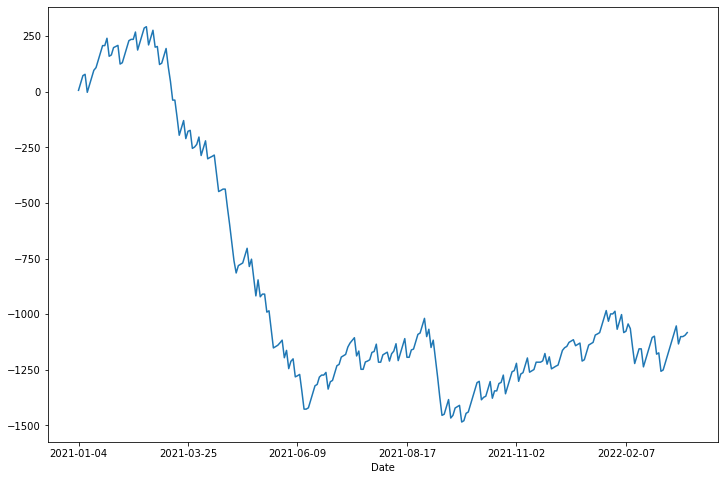

In [212]:
Cum_df["PnL"].cumsum().plot(figsize=(12,8))

c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Date'>

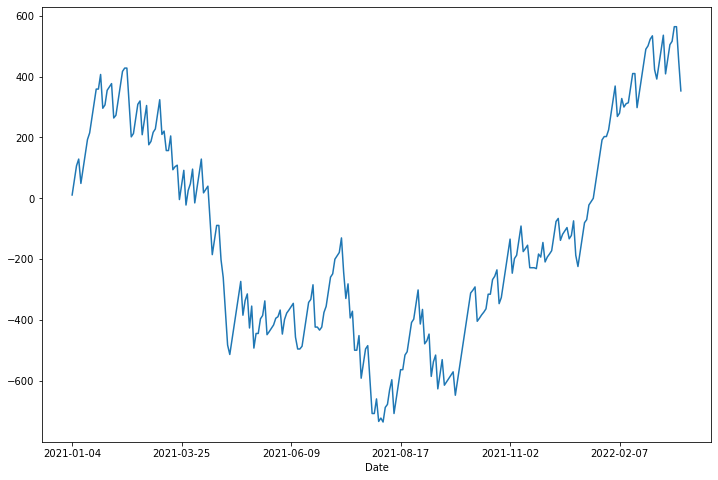

In [207]:
Cum_df["PnL"].cumsum().plot(figsize=(12,8)) # 50,35

<AxesSubplot:xlabel='Date'>

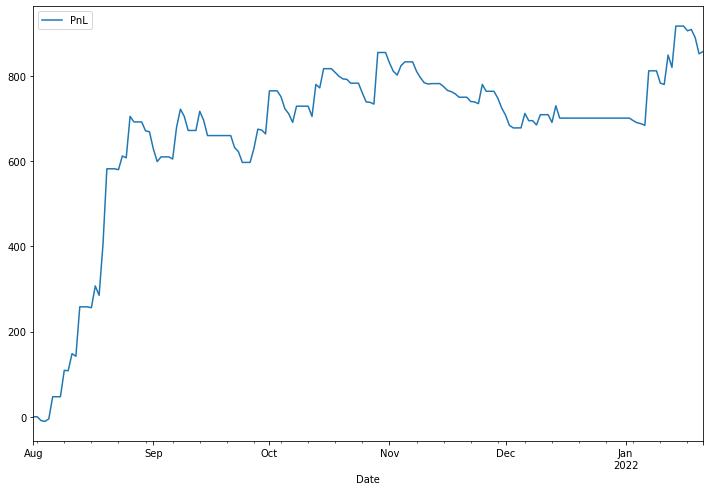

In [47]:
Cum_df.cumsum().plot(figsize=(12,8))

In [389]:
import json
data_path = os.path.join(parent, "HistoricData", "MXF")
if not os.path.isdir(data_path):
    os.makedirs(data_path)
for k, v in dfs.items():
    tdStr = k.strftime("%Y-%m-%d")
    with open(os.path.join(data_path, f"MXF_{tdStr}.json"), 'w') as f:
        v = v.reset_index()
        v.datetime = v.datetime.apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S.%f"))
        json.dump(list(v.T.to_dict().values()), f)